In [513]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import nltk
from nltk import tokenize
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk import pos_tag_sents
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anis.bouhamadouche/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anis.bouhamadouche/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anis.bouhamadouche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/anis.bouhamadouche/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anis.bouhamadouche/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [507]:
!conda python -m spacy download en_core_web_sm

zsh:1: command not found: conda


# Load data

In [19]:
def load_tweets(path = "/"):
    tweets = []
    failed_loading = []
    count = 0
    while count <= 5000:
        try:
            tweets_df = pd.read_csv(f'{path}tweet_{count}.csv')
            tweets.append(tweets_df)
        except:
            print(f"tweets set {count} failed to load")
            failed_loading.append(count)
        count += 1
    
    tweets_df = pd.concat(tweets)
    
    return tweets_df, failed_loading

In [46]:
tweet_df, failed = load_tweets('')

tweets set 10 failed to load
tweets set 106 failed to load
tweets set 231 failed to load
tweets set 246 failed to load
tweets set 586 failed to load


/var/folders/bq/q7tqs9qn6kv1736b_sbttxxh0000gn/T/ipykernel_13904/3332804618.py:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_df = pd.read_csv(f'{path}tweet_{count}.csv')


tweets set 784 failed to load
tweets set 842 failed to load
tweets set 1209 failed to load
tweets set 1219 failed to load
tweets set 1522 failed to load
tweets set 1741 failed to load
tweets set 1939 failed to load
tweets set 2040 failed to load
tweets set 2551 failed to load
tweets set 2738 failed to load
tweets set 2800 failed to load
tweets set 2825 failed to load


/var/folders/bq/q7tqs9qn6kv1736b_sbttxxh0000gn/T/ipykernel_13904/3332804618.py:7: DtypeWarning: Columns (0,1,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_df = pd.read_csv(f'{path}tweet_{count}.csv')
/var/folders/bq/q7tqs9qn6kv1736b_sbttxxh0000gn/T/ipykernel_13904/3332804618.py:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_df = pd.read_csv(f'{path}tweet_{count}.csv')


tweets set 3295 failed to load
tweets set 3340 failed to load
tweets set 3347 failed to load
tweets set 3459 failed to load
tweets set 4684 failed to load
tweets set 4820 failed to load
tweets set 4880 failed to load


# EDA

In [47]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2628954 entries, 0 to 487
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unnamed: 0              object 
 1   author_id               object 
 2   username                object 
 3   text                    object 
 4   created_at              object 
 5   retweets                float64
 6   replies                 float64
 7   likes                   float64
 8   quote_count             object 
 9   in_reply_to_user_id     object 
 10  geo                     object 
 11  referenced_tweets_id    object 
 12  referenced_tweets_type  object 
 13  lang                    object 
dtypes: float64(3), object(11)
memory usage: 300.9+ MB


In [52]:
# tweet_df.drop(columns='Unnamed: 0', inplace=True)
tweet_df.head()

author_id                       username  \
0   872853655879245824                 Dapper Dan Man   
1             41002137                   John Hanover   
2  1392481589762867203                   Lydia MarieM   
3  1432401228357533702                        Ink-217   
4             16751631  Tina Calcara 🌊🐶🐱🐎🐝🏳️‍🌈🏳️‍⚧️🇺🇦   

                                                text  \
0  @JohnHanover2 @SweetGobsOfTom @JenaGriswold Go...   
1  RT @PattyArquette: Now that Elon is opening th...   
2  RT @newsmax: Coming on the heels of Tesla CEO ...   
3  RT @msbwul: #RetireRubio  #DeathSantis Repubs ...   
4  @isadoraworkman @Moonla63916228 @MrAhmednurAli...   

                  created_at  retweets  replies  likes quote_count  \
0  2022-04-30 23:59:59+00:00       0.0      1.0    1.0           0   
1  2022-04-30 23:59:59+00:00      65.0      0.0    0.0           0   
2  2022-04-30 23:59:59+00:00     337.0      0.0    0.0           0   
3  2022-04-30 23:59:59+00:00       8.0      0.0    0.0           0   
4  2022-04-30 23:59:59+00:00       0.0      0.0    0.0           0   

  in_reply_to_user_id  geo                               referenced_tweets_id  \
0        3448602388.0  NaN  [<ReferencedTweet id=1520550452584140801 type=...   
1                 NaN  NaN  [<ReferencedTweet id=1520528672322588674 type=...   
2                 NaN  NaN  [<ReferencedTweet id=1520547393896599552 type=...   
3                 NaN  NaN  [<ReferencedTweet id=1520522390626832391 type=...   
4          16751631.0  NaN  [<ReferencedTweet id=1520552750194507777 type=...   

                              referenced_tweets_type lang  
0  [<ReferencedTweet id=1520550452584140801 type=...   en  
1  [<ReferencedTweet id=1520528672322588674 type=...   en  
2  [<ReferencedTweet id=1520547393896599552 type=...   en  
3  [<ReferencedTweet id=1520522390626832391 type=...   en  
4  [<ReferencedTweet id=1520552750194507777 type=...   en

In [53]:
tweet_df.drop_duplicates(inplace=True)

In [54]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433073 entries, 0 to 487
Data columns (total 13 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   author_id               object 
 1   username                object 
 2   text                    object 
 3   created_at              object 
 4   retweets                float64
 5   replies                 float64
 6   likes                   float64
 7   quote_count             object 
 8   in_reply_to_user_id     object 
 9   geo                     object 
 10  referenced_tweets_id    object 
 11  referenced_tweets_type  object 
 12  lang                    object 
dtypes: float64(3), object(10)
memory usage: 259.9+ MB


In [55]:
tweet_df.reset_index(inplace=True)

In [57]:
tweet_df.text[10]

'@stillawake That’s Labour’s democracy then. Fake governance that isn’t transparent or accountable to us, the electorate and their representatives. \n\nAnd Labour are advocating this. They are so far removed from their roots it’s farcical'

In [60]:
tweet_df.isna().sum()

index                           0
author_id                       1
username                      207
text                            1
created_at                     15
retweets                       15
replies                        27
likes                          29
quote_count                    22
in_reply_to_user_id       2021910
geo                       2416186
referenced_tweets_id       342594
referenced_tweets_type     342594
lang                           29
dtype: int64

In [62]:
tweet_df.dropna(subset=['text'], inplace= True)

In [64]:
tweet_df.author_id.nunique()

1370845

## Which usernames that has most tweets during the period of 01/01/2022 - 01/05/2022?

In [73]:
tweet_df.groupby(['username'])['username'].size().sort_values()[-10:]

username
Fox News                     879
David                        914
Amazon Help                  932
Pramila Jayapal              932
Joe Biden                   1004
Alexandria Ocasio-Cortez    1146
President Biden             1414
Are You...                  1730
.                           1779
Elon Musk                   2734
Name: username, dtype: int64

In [93]:
tweet_df[tweet_df.username == 'Elon Musk']['text']

3753       Profiteering! Not inflation!\n\nThe money prin...
5139       RT @moonyeth: Reaching Mars has never been thi...
7060       RT @NewsNancy9: JUST IN: @WaltDisneyCo employe...
8592       RT @raztweets: Usually not a fan of ‘social ex...
10096      Catax automatically audits all transactions so...
                                 ...                        
2429930    RT @paul_ducker: Dirty air affects 97% of UK h...
2430423    RT @AmbokoJH: Scrap Metal Regulations 2022\nAn...
2430764    RT @Fridays4future: According to the https://t...
2431293    RT @Chellaney: Irony of ironies: Those waging ...
2432531    the bbc is a tax that is enforced on us it sho...
Name: text, Length: 2734, dtype: object

In [92]:
tweet_df.groupby(['author_id'])['author_id'].size().sort_values()[-10:]

author_id
498245863               707
1508948283674169346     776
1513899747178090496     814
1514234685077000335     870
1518199523197464577     920
1517080961682493440     977
1519660023852695553     979
1343499740948946944    1036
85741735               1074
4286721082             1920
Name: author_id, dtype: int64

In [91]:
print(tweet_df.lang.unique())
print(f"\nNumber of languages covered: {tweet_df.lang.nunique()}")

['en' 'pt' 'es' 'ja' 'nl' 'und' 'de' 'in' 'ko' 'fr' 'tr' 'tl' 'ar' 'ca'
 'th' 'eu' 'it' 'ru' 'hi' 'el' 'zh' 'am' 'pl' 'et' 'or' 'ml' 'lt' 'lv'
 'no' 'ro' 'te' 'ur' 'da' 'fa' 'ta' 'fi' 'mr' 'hu' 'ht' 'sv' 'vi' 'sl'
 'uk' 'bg' 'cy' 'ne' 'gu' 'si' 'cs' 'iw' 'bn' 'is' 'hy' 'pa' 'kn' 'ckb'
 'ps' 'lo' nan 'sr' 'my' 'km']

Number of languages covered: 61


## Number of tweets in English

In [149]:
tweet_df[tweet_df.lang == 'en'].shape[0]

2005818

# Word Analysis

In [209]:
def normalize_tweet_tokens(tweets):
    """Normalize the text: lowercase, remove links, tokenize into words, remove stopwords, and lemmatize
            The resulting words' list will be ready to be processed
        
    Parameters:
    -----------
    tweets    : list or pd.Series containing the text of tweets
    
    Returns:
    --------
    tweets_cp : list of normalized words
    """
    
    tweets_cp = tweets.copy()
    
    # make sure to convert the supplied series to a list
    if isinstance(tweets_cp, pd.Series):
        tweets_cp = tweets_cp.values
    
    # convert to lowercase
    tweets_cp = [x.lower() for x in tweets_cp]
    
    # remove links
    tweets_cp = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', x) for x in tweets_cp]
    
    # tokenize sentences into words
    tweets_cp = [word_tokenize(x) for x in tweets_cp]
    tweets_cp = [item for sublist in tweets_cp for item in sublist]
    
    # removing stop words before lemmatizing
    stop_words = stopwords.words('english')
    stop_words.append('rt')
    tweets_cp = [w for w in tweets_cp if w not in stop_words and w.isalnum()]
    
    # lemmatize using WordNet
    wnl = WordNetLemmatizer()
    tweets_cp = [wnl.lemmatize(w) for w in tweets_cp]
    
    return tweets_cp

In [210]:
normalized_tweets = normalize_tweet_tokens(tweet_df[tweet_df.lang == 'en'].text)

In [211]:
len(normalized_tweets)

26286383

## Plot FreqDist

In [212]:
fdist = nltk.FreqDist(normalized_tweets).most_common(40)
fdist = pd.Series(dict(fdist))

<AxesSubplot:title={'center':'Frequency Distribution'}, xlabel='Lemmatised Words', ylabel='Counts'>

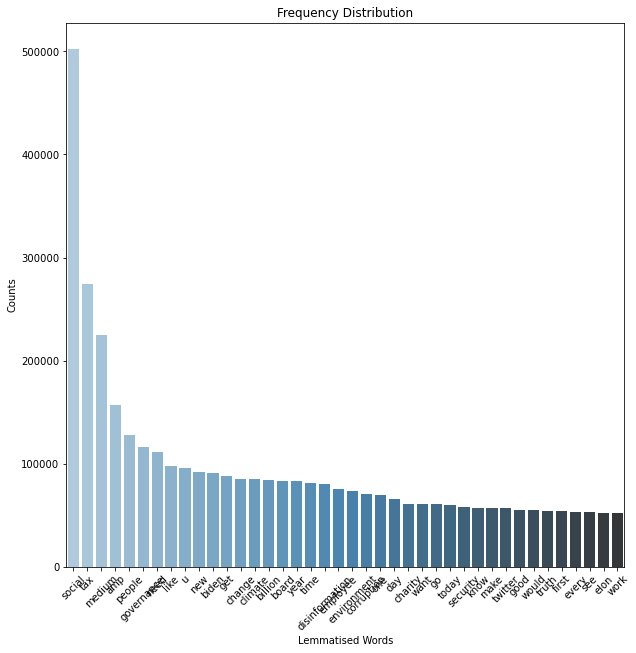

In [213]:
fig, ax = plt.subplots(figsize=(10,10))

freqdp = sns.barplot(x = fdist.index, y = fdist.values, ax = ax, palette="Blues_d")
plt.xticks(rotation=45);
freqdp.set(xlabel = 'Lemmatised Words', ylabel = 'Counts', title = 'Frequency Distribution')
freqdp

In [215]:
fig.savefig("freqDist.png")

## Co-occurence

In [544]:
def cooccurence_data_prep(tweets):
    """prepare tweets to build co-occurence network: lowercase, remove links, 
            segment sentences, tokenize those sentences, remove stopwords, 
            and perform lemmatization.
        
    Parameters:
    -----------
    tweets    : list or pd.Series containing the text of tweets
    
    Returns:
    --------
    nodes : 2D list containing where each row is a list of normalized words of a given sentence
    """
    sentences = tweets.copy()
    
    # make sure to convert the supplied series to a list
    if isinstance(sentences, pd.Series):
        sentences = sentences.values
    
    # remove links
    sentences = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', x) for x in sentences]
    
    # sentence segmentation
    sentences = np.concatenate([tokenize.sent_tokenize(s) for s in sentences])
    
    # convert to lowercase and tokenize into words
    sentences = [word_tokenize(x.lower()) for x in list(sentences)]
    
        
    # pos sentences
    sentences = pos_tag_sents(sentences)
    
    stop_words = stopwords.words('english')
    stop_words.append('rt')

    wnl = WordNetLemmatizer()
    nodes_data = []
    # lemmatize and remove stop words
    for s in sentences:
        nodes_data.append([wnl.lemmatize(w[0]) for w in s if (w[0] not in stop_words and w[1] in ['NN', 'NNS', 'NNP', 'NNPS']) and w[0].isalnum()])
    
    data = []
    for l in nodes_data:
        if len(l) > 0:
            data.append(l)
        
    return data

In [466]:
def define_coocurrence_pairs(tokenized_tweets):
    edge_list = []
    for n in tokenized_tweets:
        for i in range(len(n)-1):
            edge_list.append((n[i],n[i+1]))
    
    nodes_dict = dict.fromkeys(edge_list,0)
    for edge in edge_list:
        nodes_dict[edge] += 1
    
    # keep only pairs of words that appeared with each other more than twice
    nodes_dict = {key : val for key, val in nodes_dict.items() if val > 2}

    nodes = [ (item[0][0],item[0][1], 1/item[1]) for item in nodes_dict.items()]
    return nodes

In [546]:
nodes = cooccurence_data_prep(tweet_df[tweet_df.lang == 'en'].text[:100000])

In [547]:
# create the cooccurrence network
n = define_coocurrence_pairs(nodes[:40000])
G = nx.Graph()
G.add_weighted_edges_from(n)

In [727]:
print(f"nodes {G.number_of_nodes()}")
print(f"edges {G.number_of_edges()}")

nodes 3636
edges 6222


# Centralities

In [628]:
degree_cent = nx.degree_centrality(G)
closeness_cent = nx.closeness_centrality(G)
centrality_df = pd.DataFrame([degree_cent, closeness_cent]).transpose()
centrality_df.columns = ["Degree", "Closeness"]

In [629]:
centrality_df.sort_values('Degree', ascending= False)[:10]

Degree  Closeness
tax         0.078404   0.331215
medium      0.061348   0.330274
amp         0.048693   0.326491
people      0.039890   0.320024
corruption  0.025585   0.301532
charity     0.024209   0.277188
year        0.022008   0.307110
employee    0.021733   0.283721
climate     0.019532   0.284121
change      0.016781   0.290235

In [630]:
centrality_df.sort_values('Closeness', ascending= False)[:10]

Degree  Closeness
tax         0.078404   0.331215
medium      0.061348   0.330274
amp         0.048693   0.326491
people      0.039890   0.320024
year        0.022008   0.307110
corruption  0.025585   0.301532
money       0.012655   0.294766
time        0.015681   0.291748
change      0.016781   0.290235
day         0.013480   0.289179

In [631]:
np.corrcoef(centrality_df['Degree'], centrality_df['Closeness'])[0,1]

0.25601539579220395

In [575]:
def co_occurrence_network(term, g):
    nod = term
    neig = list(G.neighbors(nod))
    neig.append(term)
    term_graph = G.subgraph(neig)
    return term_graph

In [766]:
def plot_co_occurrence(term, g):
    
    measures = [x*900 for x in nx.degree_centrality(g).values()]
    vmin = min(measures)
    vmax = max(measures)
    cmap = plt.cm.plasma
    pos = nx.kamada_kawai_layout(g)
    f = plt.figure(3,figsize=(24,24))
    nx.draw(g, 
            edge_color = 'gray',
            node_size= measures,
            pos = pos, 
            alpha = 0.6,
            cmap=cmap,
            ax=f.add_subplot(111),
           node_color=measures,
           vmin = vmin,
           vmax = vmax)
    nx.draw_networkx_labels(g, pos= pos, font_size = 10)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)
    plt.savefig(f'{term}_coocurrence.png')

In [768]:
plot_co_occurrence('all_cooccurrence_network', G)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



## Tax co-occurrence

In [749]:
tax_graph = co_occurrence_network('tax', G)

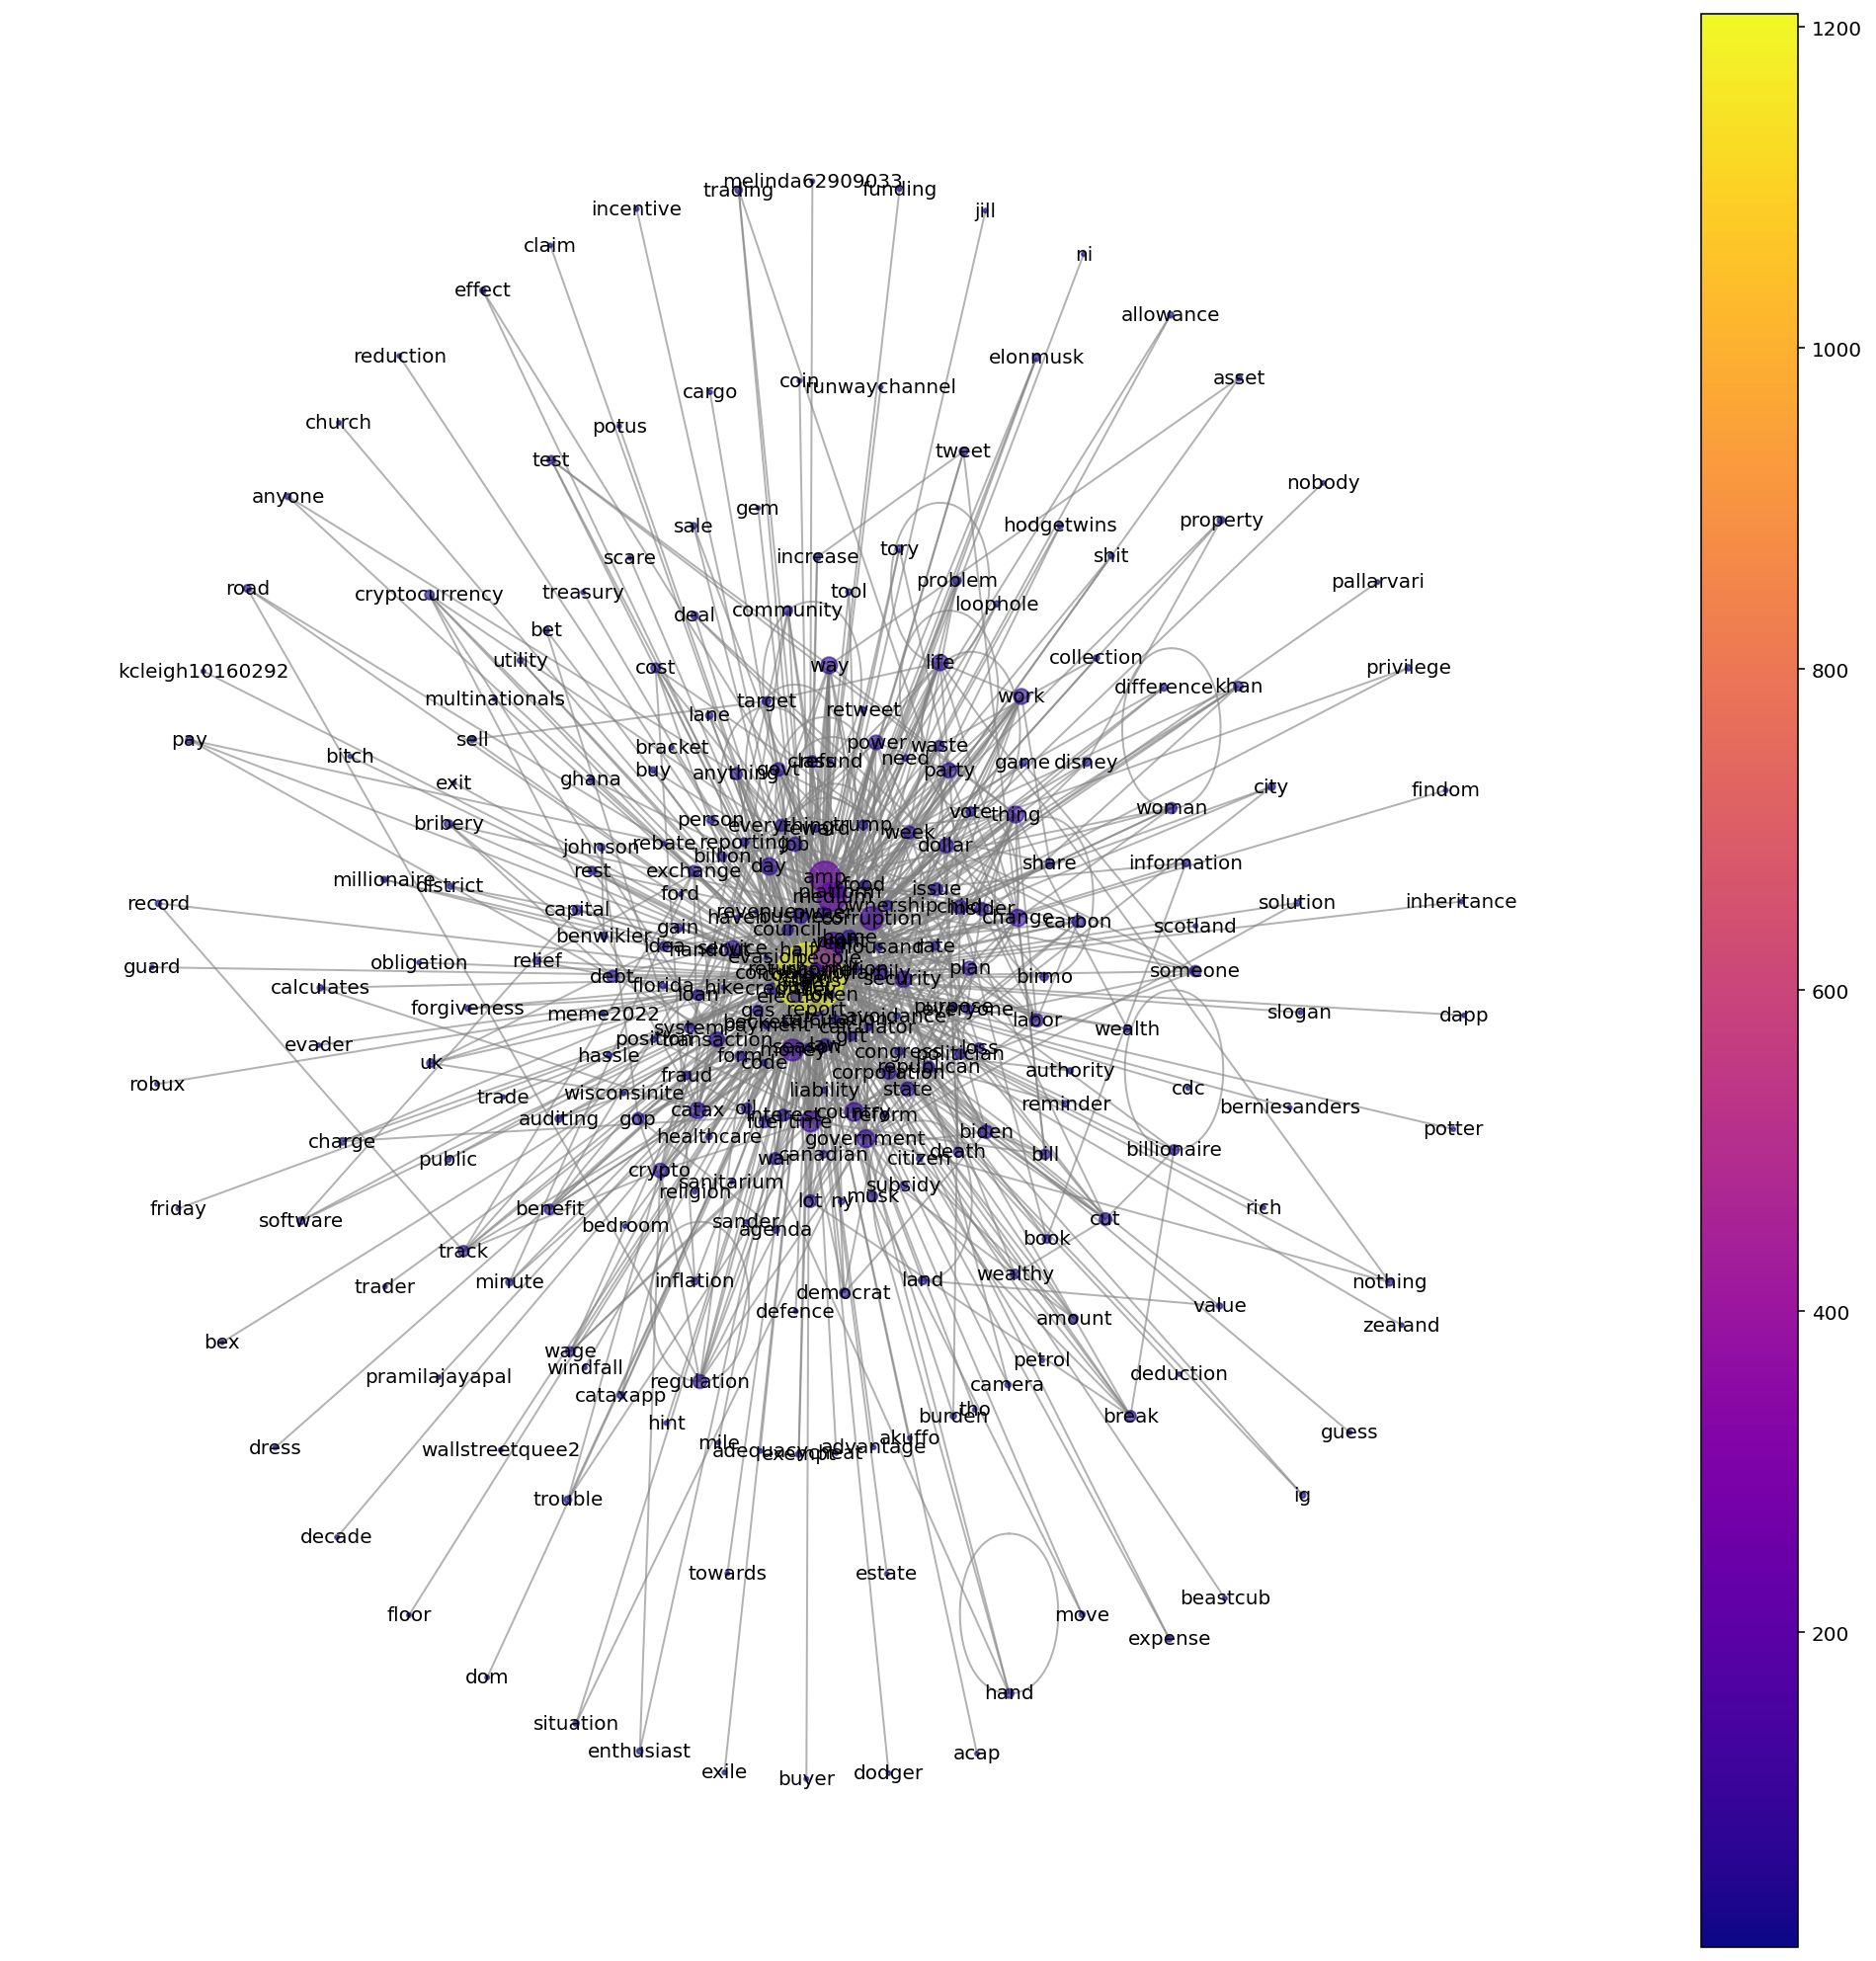

In [759]:
plot_co_occurrence('tax', tax_graph)

## Privacy co-occurence network

In [732]:
privacy_graph=co_occurrence_network('privacy', G)

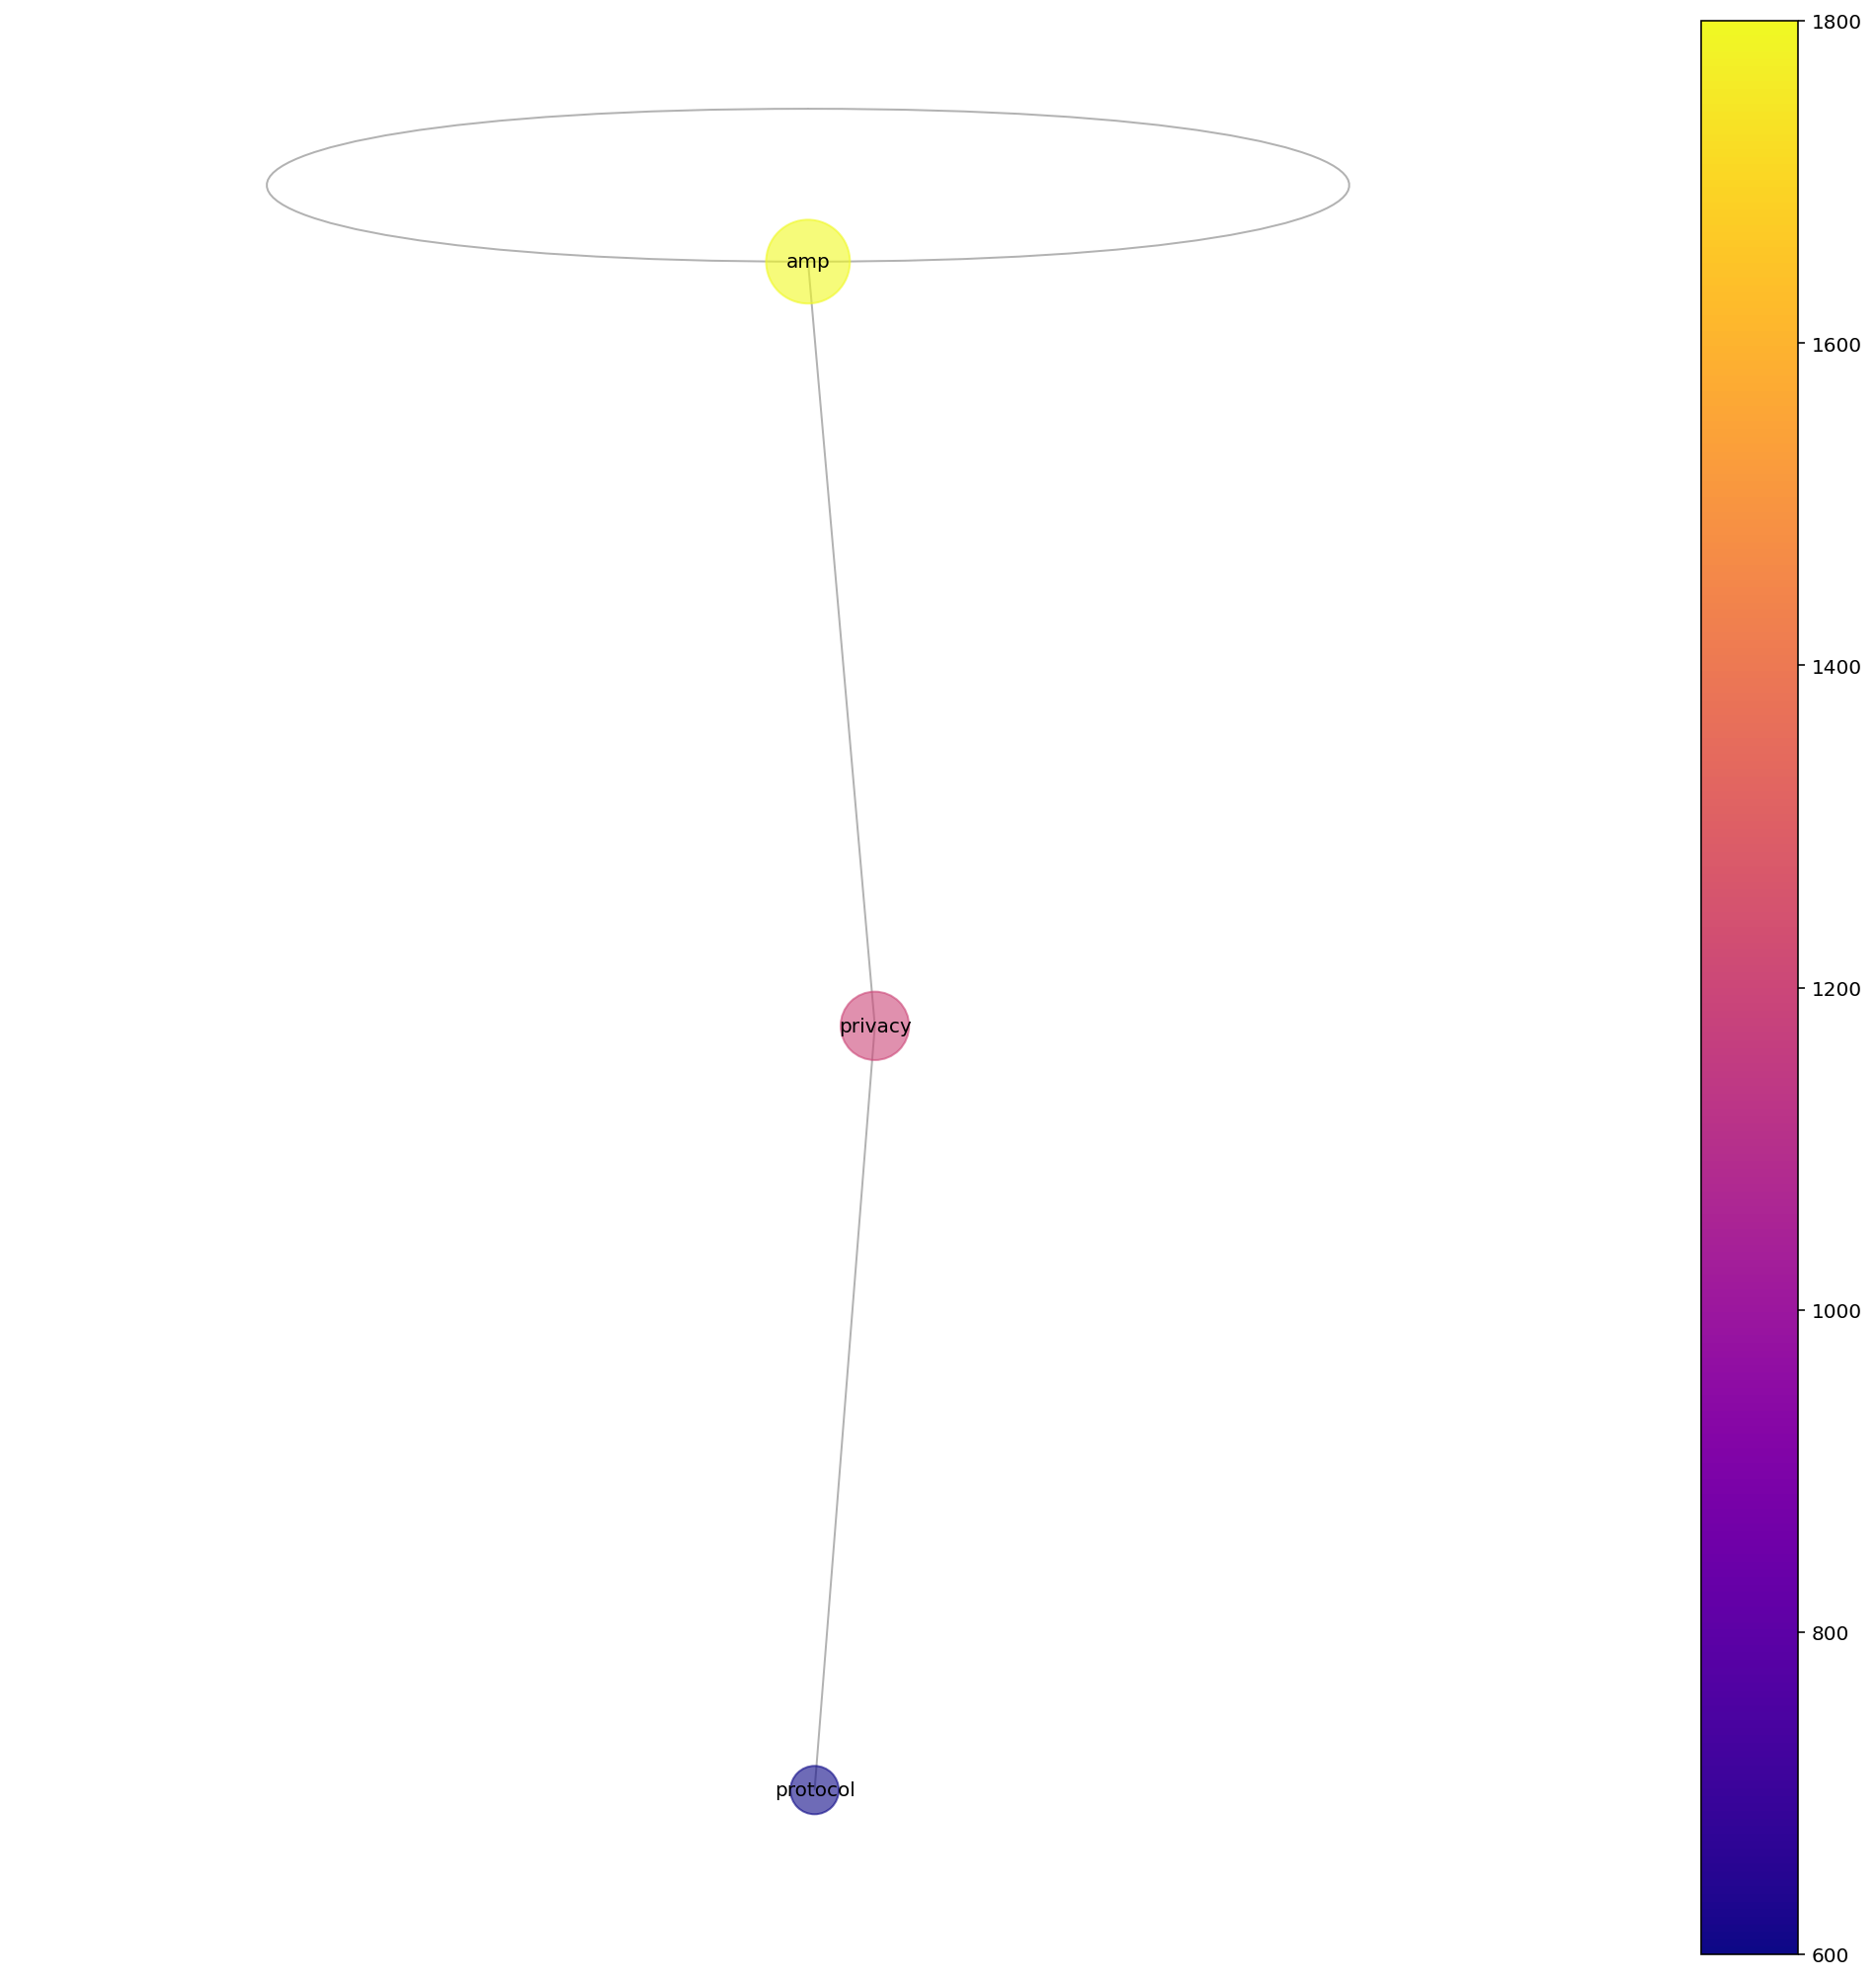

In [760]:
plot_co_occurrence('privacy', privacy_graph)

## Social Co-occurrence

In [734]:
social_graph=co_occurrence_network('social', G)

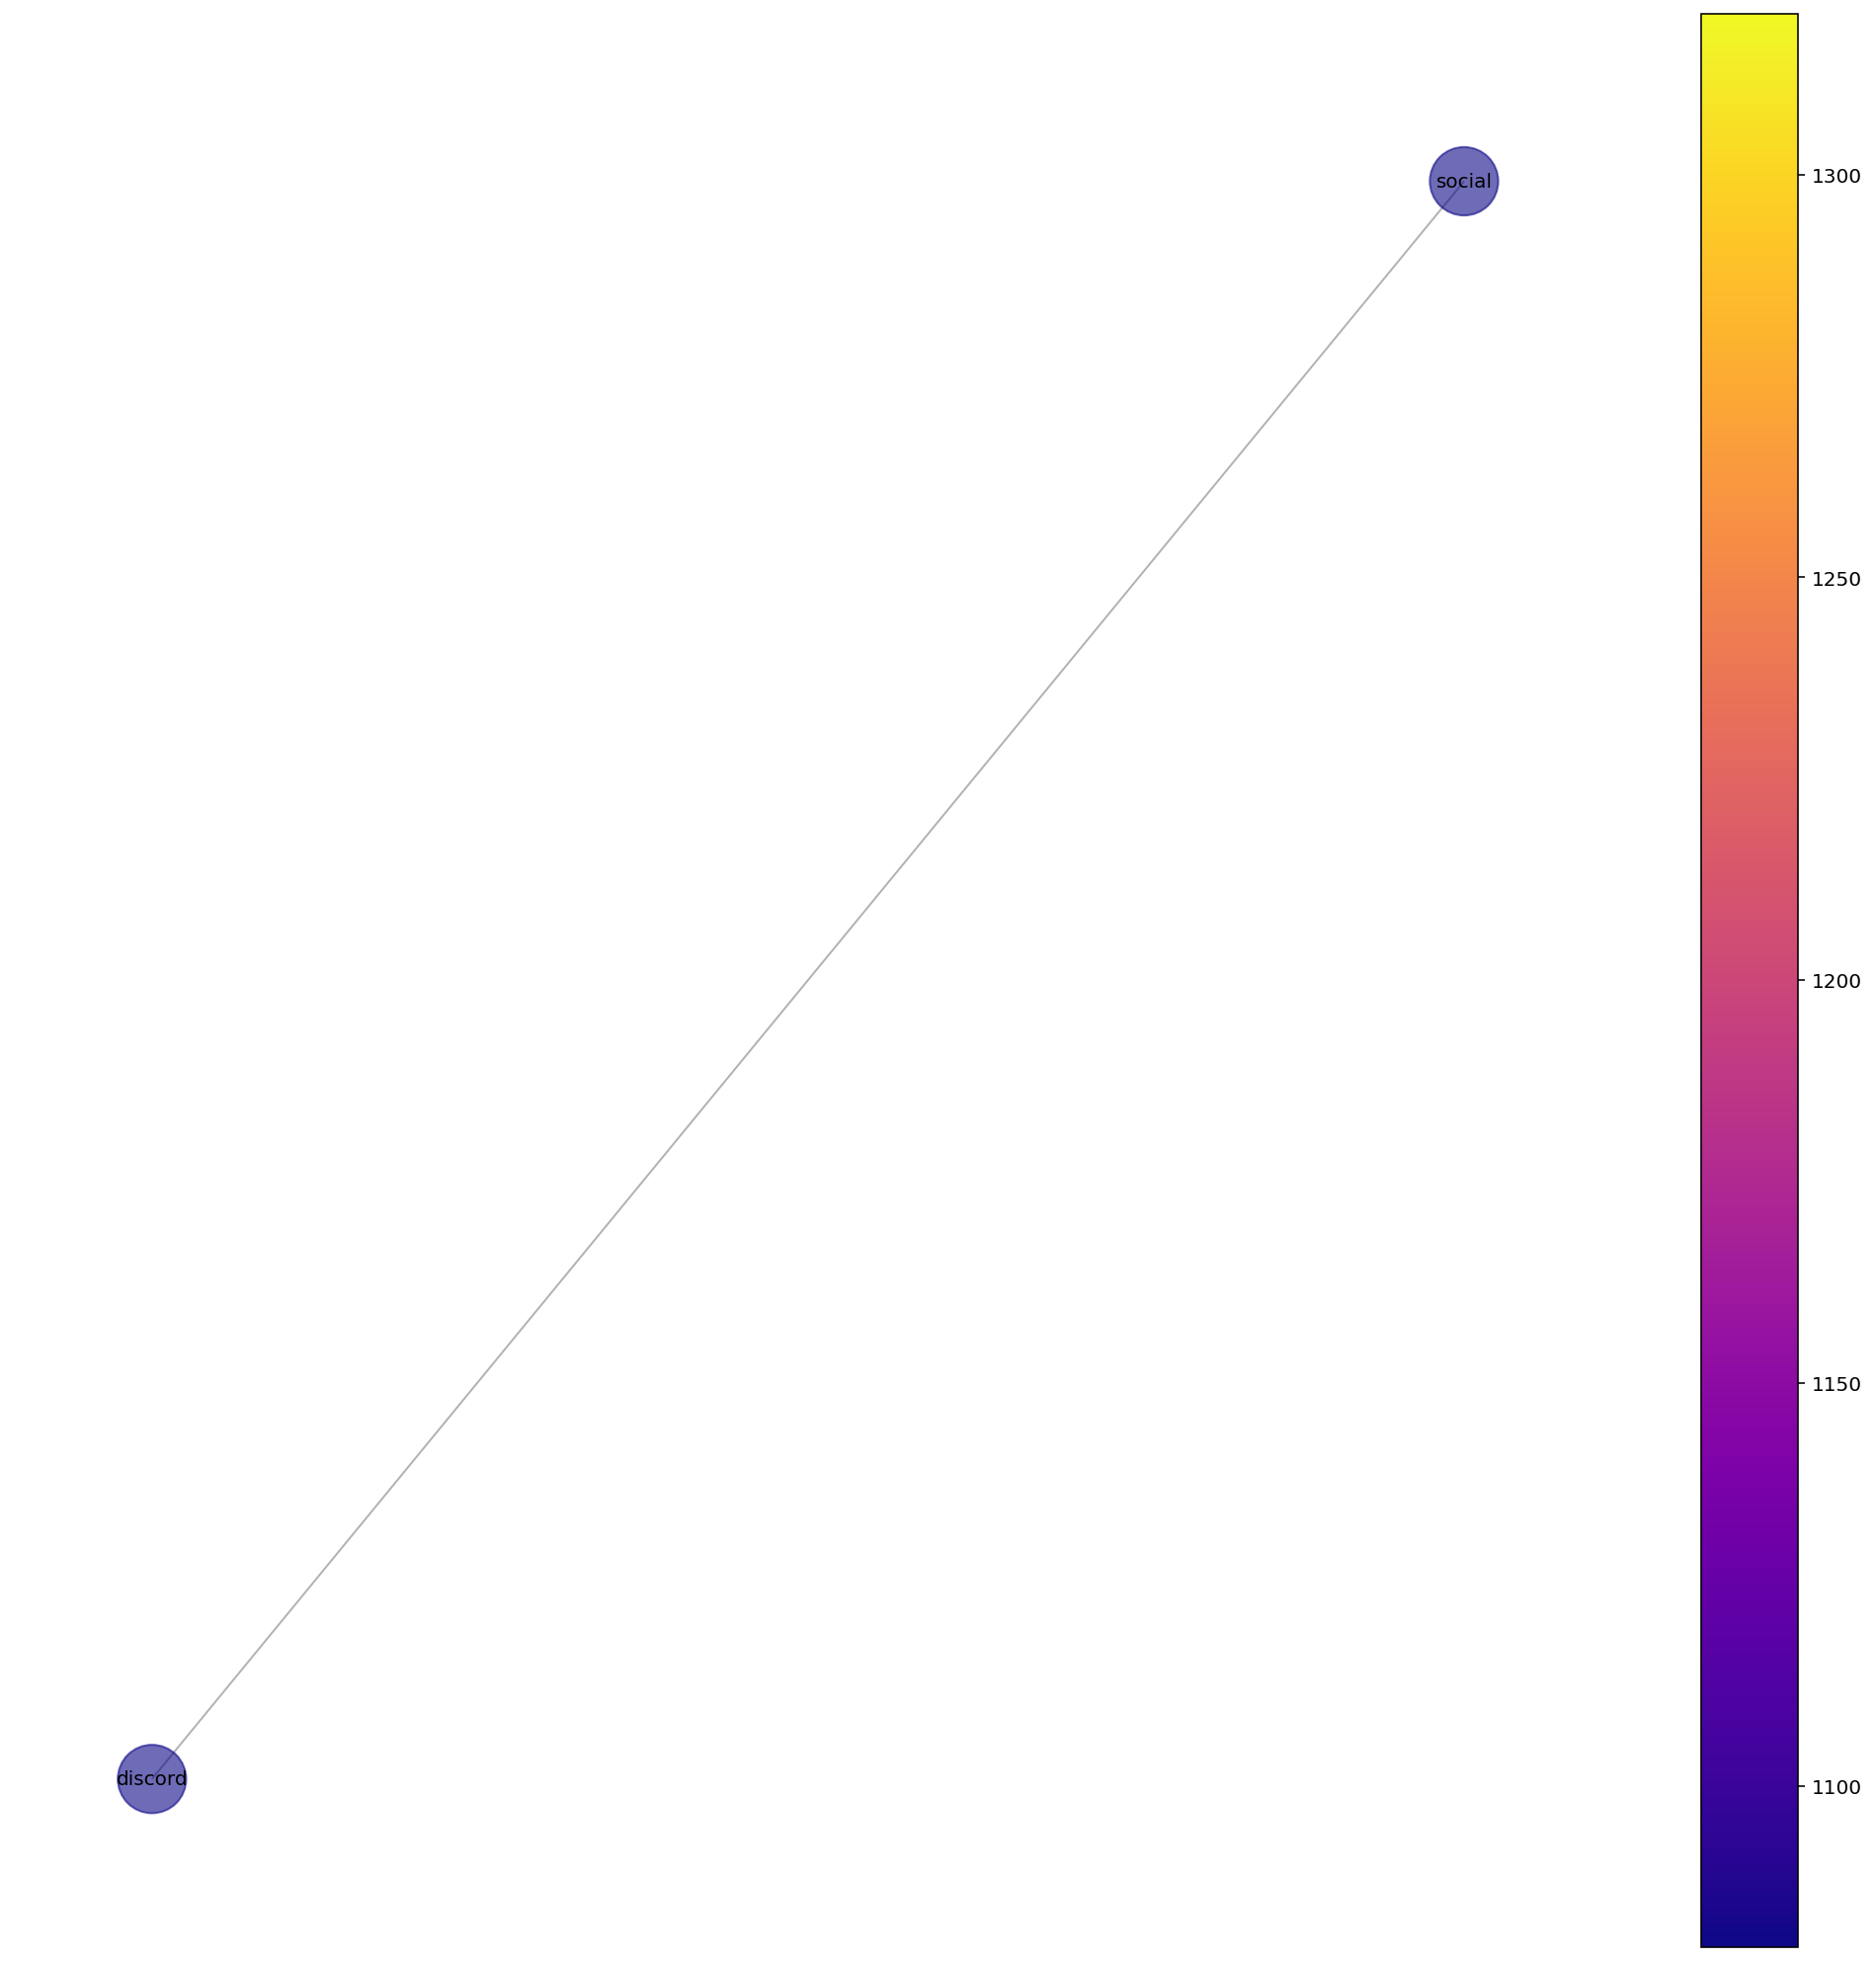

In [761]:
plot_co_occurrence('social', social_graph)

# Climate Co-occurrence

In [745]:
climate_graph=co_occurrence_network('climate', G)

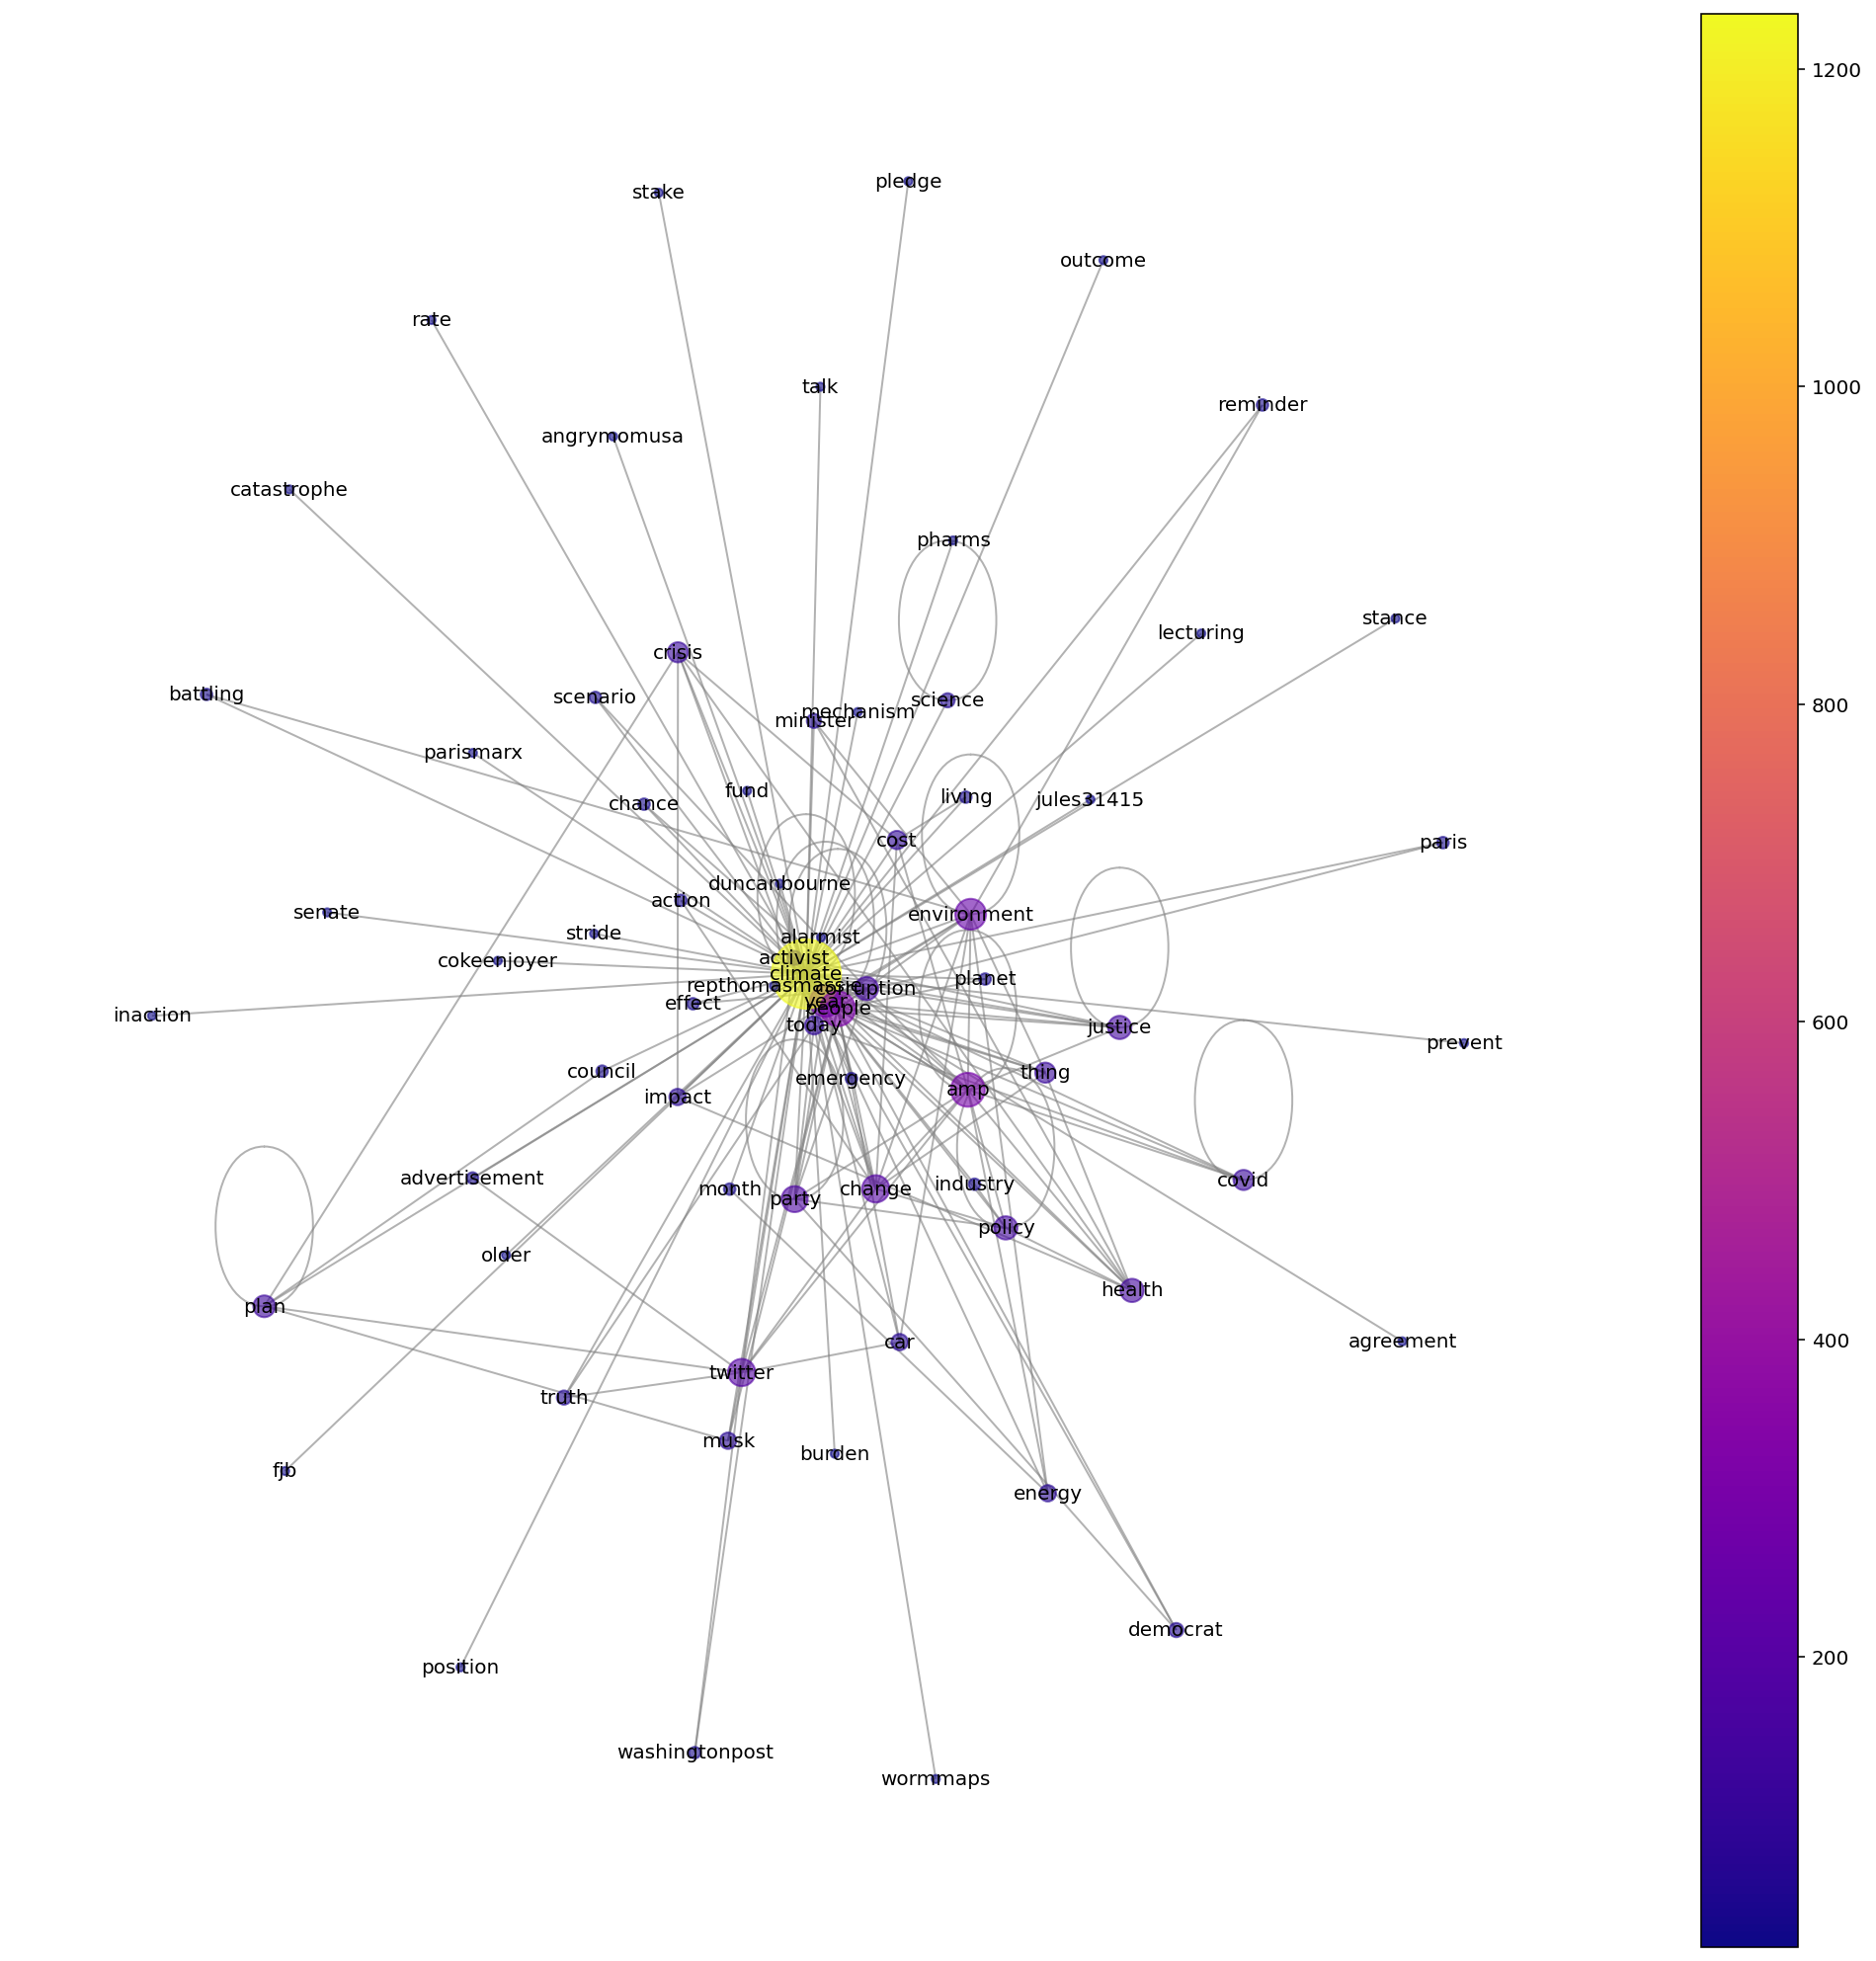

In [762]:
plot_co_occurrence('climate', climate_graph)

# Corruption co-occurrence

In [747]:
corruption_graph=co_occurrence_network('corruption', G)

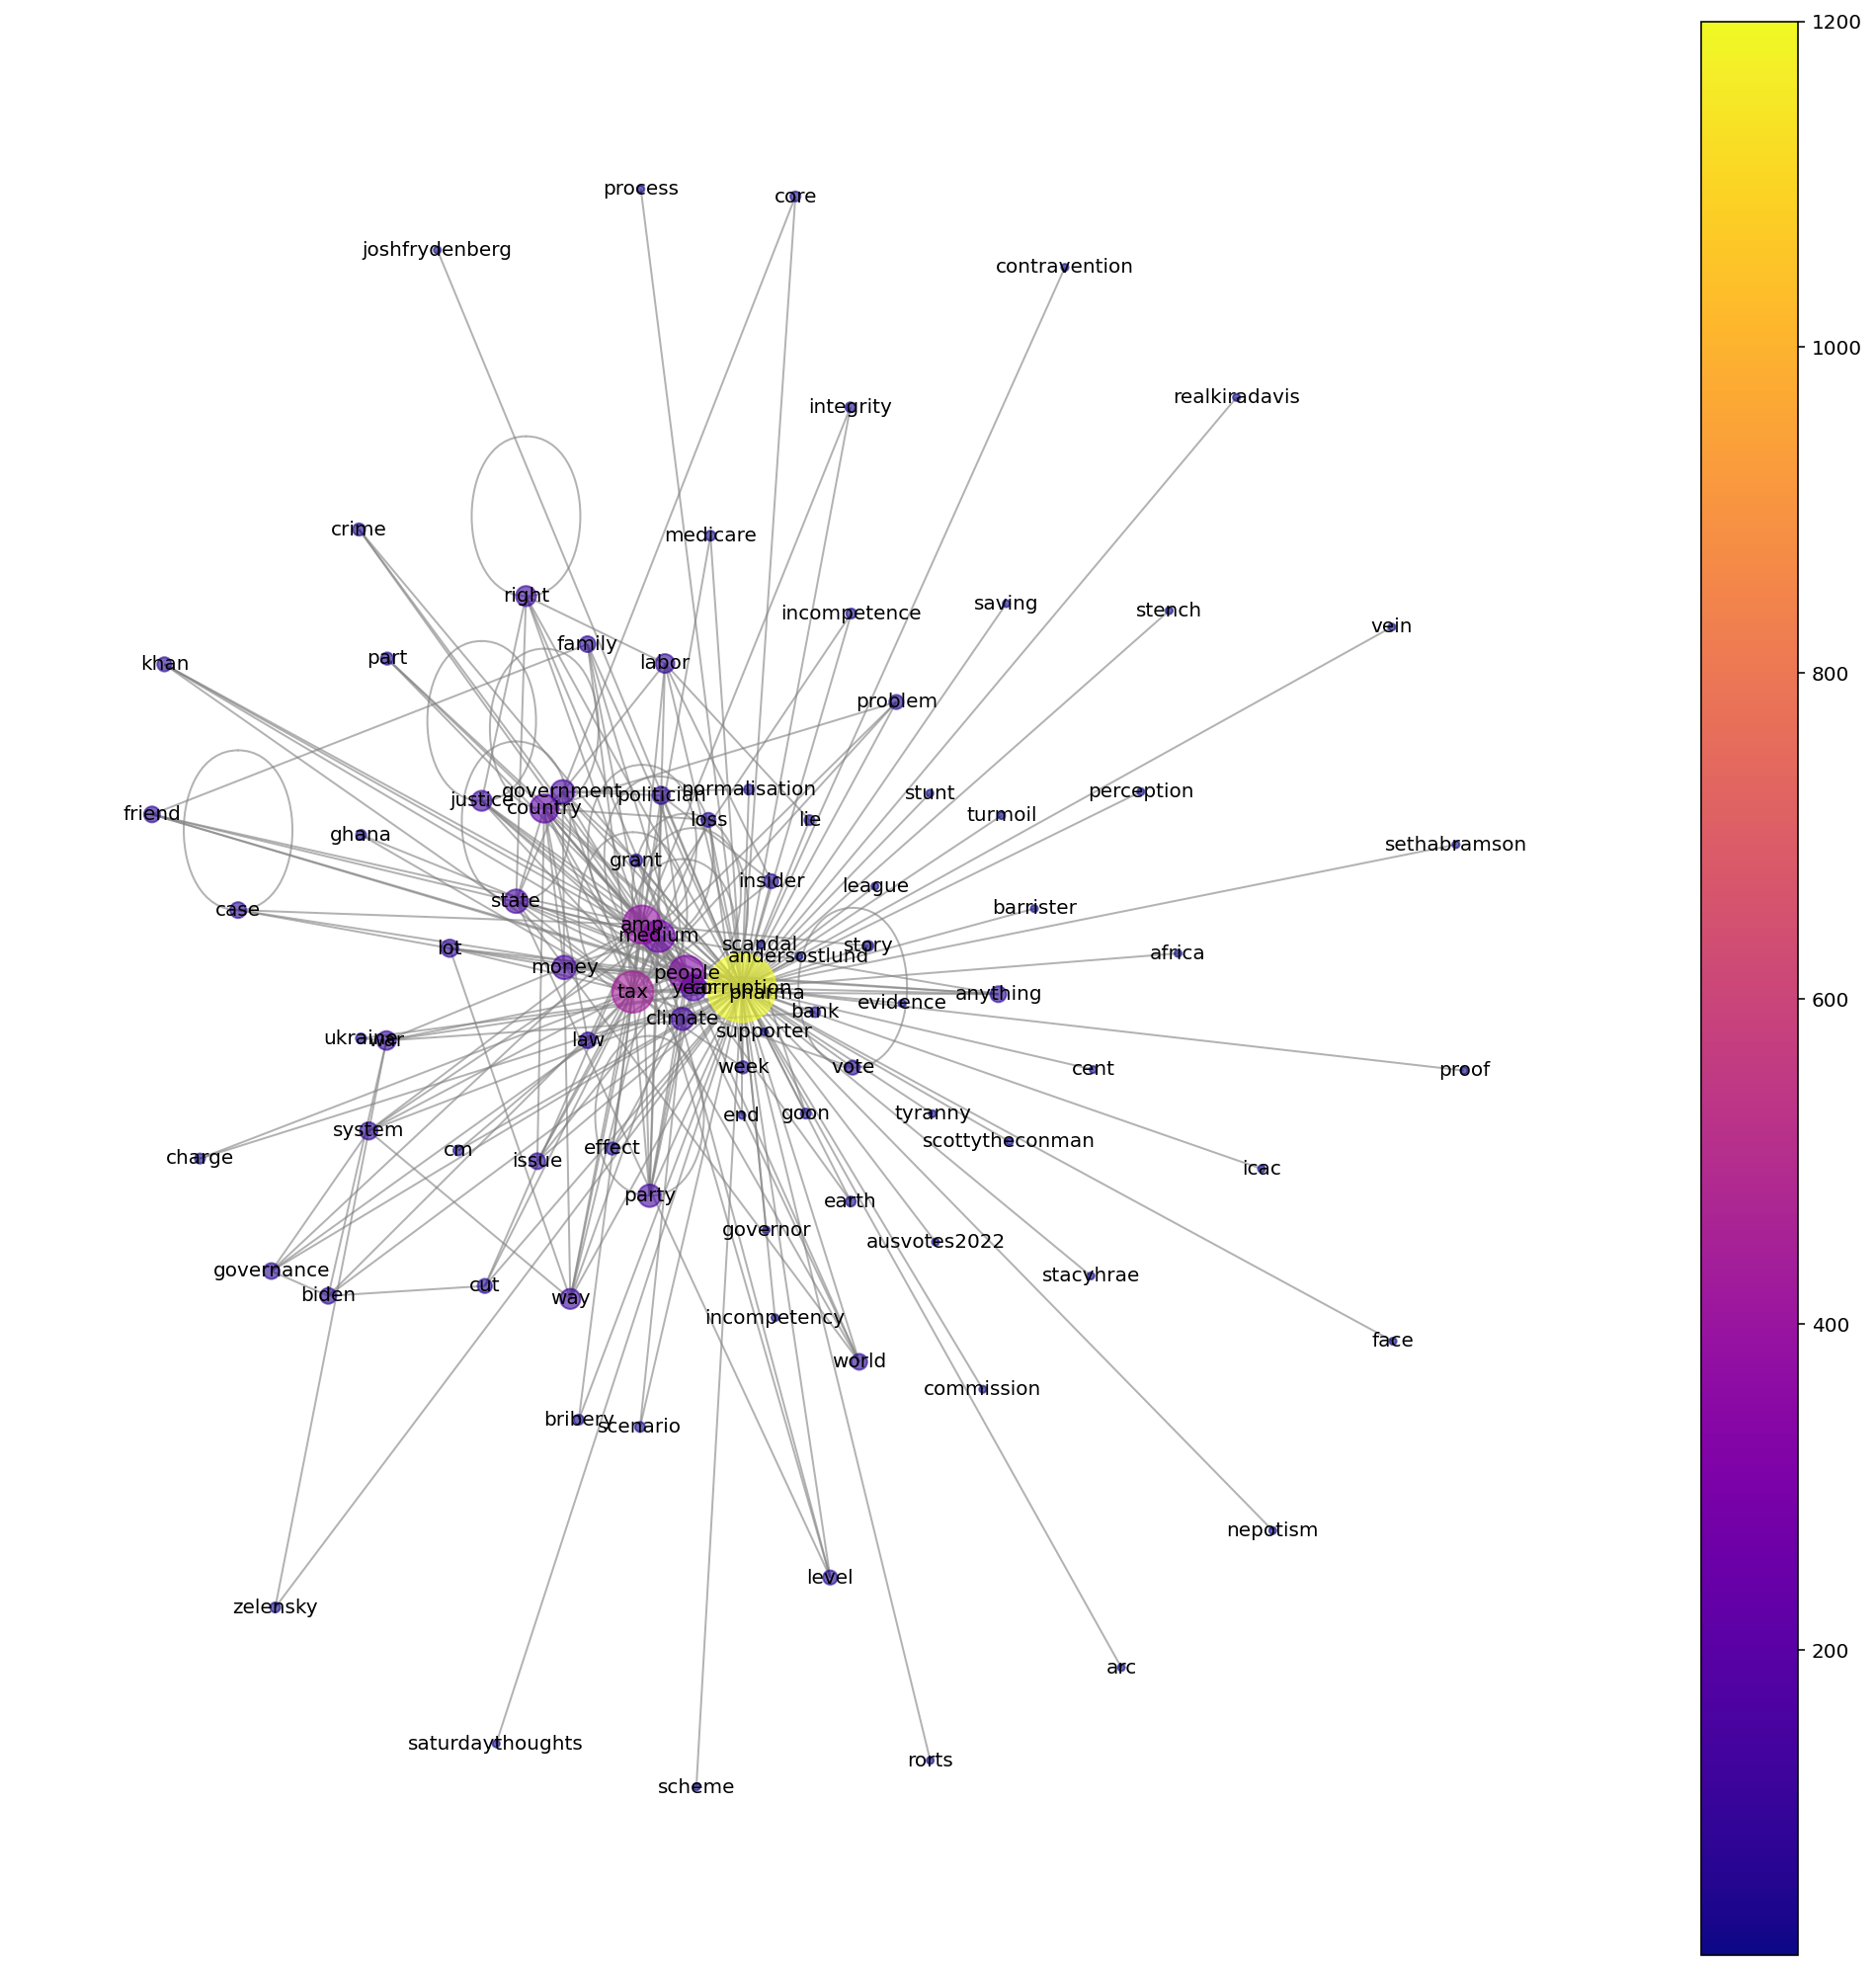

In [763]:
plot_co_occurrence('corruption', corruption_graph)

# Environment Co-occurrence

In [740]:
env_graph=co_occurrence_network('environment', G)

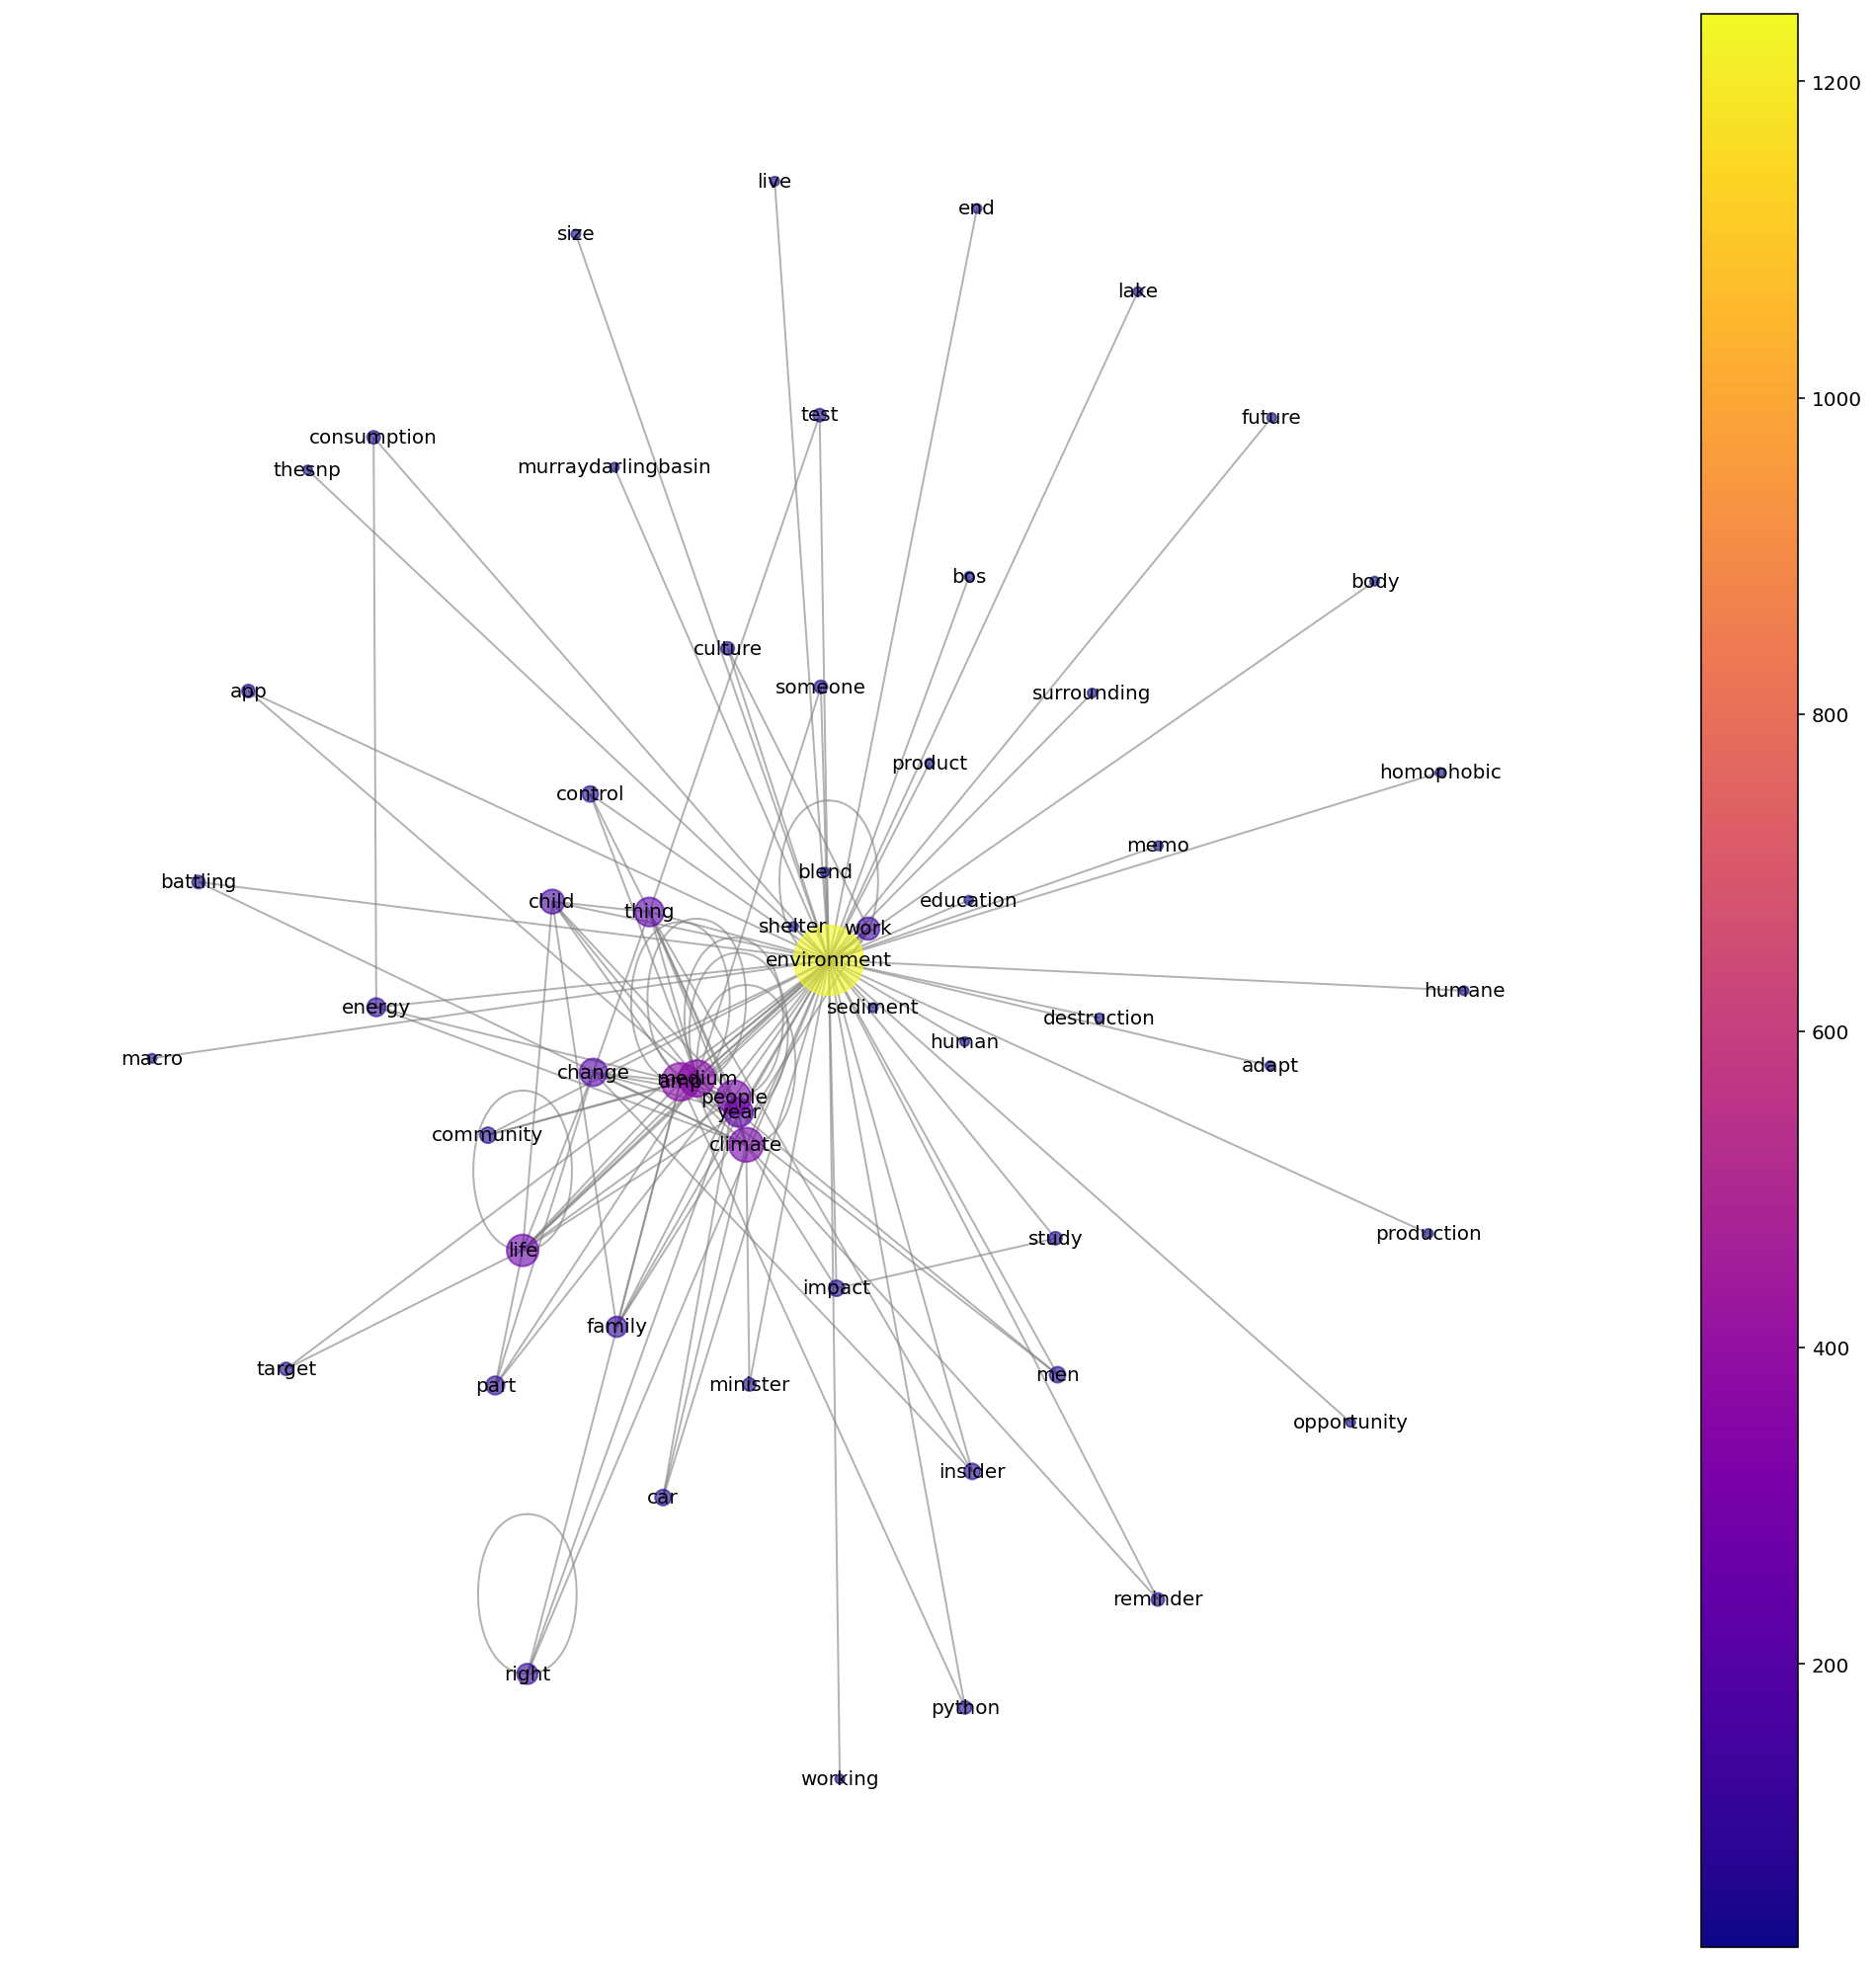

In [764]:
plot_co_occurrence('environment', env_graph)

## Charity co-occurrence

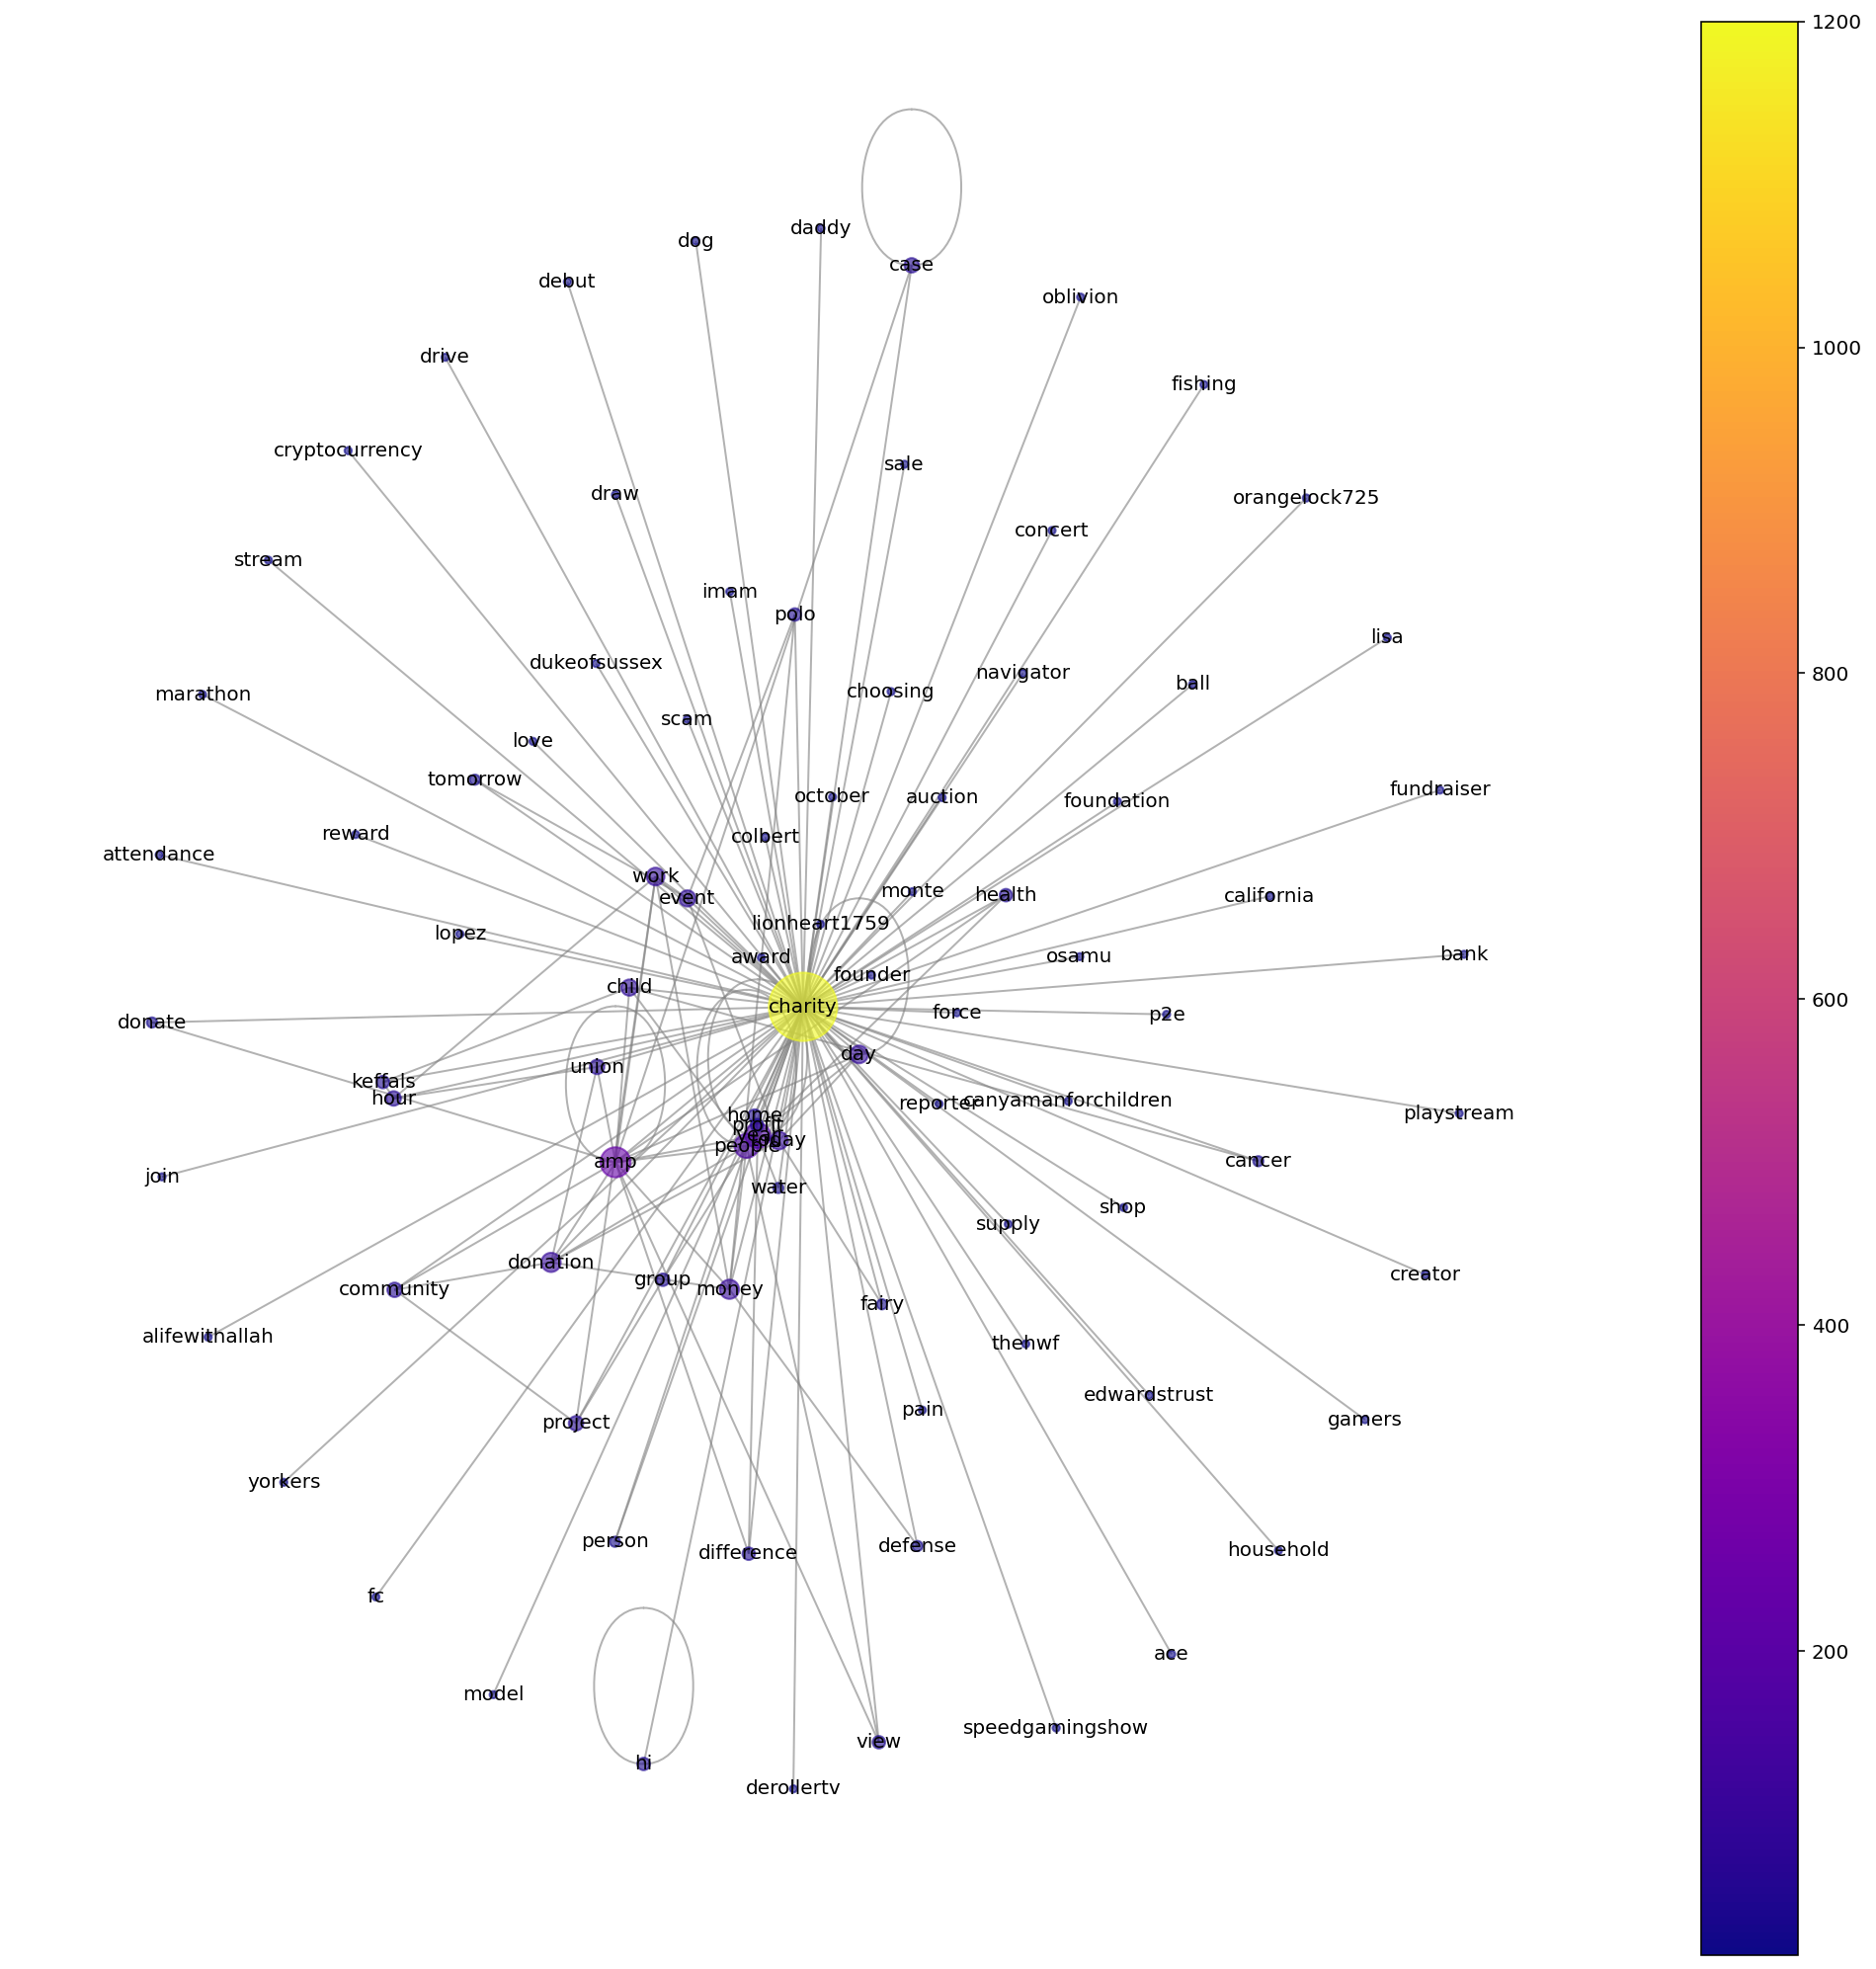

In [765]:
charity_graph=co_occurrence_network('charity', G)
plot_co_occurrence('charity', charity_graph)

## User Data

In [594]:
def load_users(path = ""):
    users = []
    failed_loading = []
    count = 0
    while count <= 5000:
        try:
            users_df = pd.read_csv(f'{path}users_{count}.csv')
            users.append(users_df)
        except:
            print(f"users set {count} failed to load")
            failed_loading.append(count)
        count += 1
    
    users_df = pd.concat(users)
    
    return users_df, failed_loading

In [595]:
users_df = load_users()

In [603]:
users_df = users_df[0]

In [606]:
users_df.drop(columns='Unnamed: 0', inplace = True)

In [609]:
users_df.isna().sum()

id                    0
username            236
description     2721818
followers             0
following             0
tweets_count          0
location        1085540
dtype: int64

In [613]:
users_df = users_df.rename(columns={'id':'author_id'})

In [614]:
users_df.head()

author_id                       username  description  followers  \
0   872853655879245824                 Dapper Dan Man          NaN        102   
1           3448602388                   John Hanover          NaN        133   
2             41002137                   Lydia MarieM          NaN        995   
3  1392481589762867203                        Ink-217          NaN       1032   
4  1432401228357533702  Tina Calcara 🌊🐶🐱🐎🐝🏳️‍🌈🏳️‍⚧️🇺🇦          NaN       1249   

   following  tweets_count        location  
0        218          5193             NaN  
1        271          2005   Colorado, USA  
2        207        114776            L.A.  
3       2006          4492  Louisiana, USA  
4       1576         51248  Sebastopol, CA

## NOTE: The topic modelling was done on colab at the same time as this part (locally) to gain some time 
(Alternatively, I would use Databricks for data processing tasks and AML or AWS SageMaker for training topic models)